## ListNet

In [4]:
import math

import numpy as np
import torch
import torch.nn as nn
from catboost.datasets import msrank_10k
from sklearn.preprocessing import StandardScaler

from typing import List

class ListNet(torch.nn.Module):
    def __init__(self, num_input_features: int, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        # укажите архитектуру простой модели здесь
        self.model = nn.Sequential(
            nn.Linear(num_input_features,hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, input_1: torch.Tensor) -> torch.Tensor:
        logits = self.model(input_1)
        return logits

In [21]:
train_df, test_df = msrank_10k()
X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
query_ids_train = train_df[1].values.astype(int)

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
query_ids_test = test_df[1].values.astype(int)

In [22]:
X_train

array([[3., 3., 0., ..., 0., 0., 0.],
       [3., 0., 3., ..., 0., 0., 0.],
       [3., 0., 2., ..., 0., 0., 0.],
       ...,
       [2., 0., 2., ..., 0., 0., 0.],
       [2., 0., 1., ..., 0., 0., 0.],
       [2., 1., 1., ..., 0., 0., 0.]])

In [23]:
y_train

array([2., 2., 0., ..., 2., 2., 1.])

In [24]:
query_ids_train

array([   1,    1,    1, ..., 1291, 1291, 1291])

In [25]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def _scale_features_in_query_groups(inp_feat_array: np.ndarray,
                                        inp_query_ids: np.ndarray) -> np.ndarray:
        #создаем массив с данными 
        scaled_feats = np.zeros_like(inp_feat_array)

        #уникальные группы по id 
        unique_inp_query_ids = np.unique(inp_query_ids)
        for query_id in unique_inp_query_ids:
            # маска с текущем query_id 
            mask = inp_query_ids == query_id
            # отбираем фичи по query_id и преобразуем 
            feats = inp_feat_array[mask]
            scaler = StandardScaler()
            feats_scaled = scaler.fit_transform(feats)
            
            #заполняем query_id 
            scaled_feats[mask] = feats_scaled
            
        return scaled_feats

def prepare_data(X_train, y_train, query_ids_train,
            X_test, y_test, query_ids_test):
        
        X_train_scaled = _scale_features_in_query_groups(X_train,query_ids_train)
        X_test_scaled = _scale_features_in_query_groups(X_test,query_ids_test)

        X_train = torch.FloatTensor(X_train_scaled)
        X_test = torch.FloatTensor(X_test_scaled)
        ys_train = torch.FloatTensor(y_train)
        ys_test = torch.FloatTensor(y_test)
        return X_train, ys_train, query_ids_train, X_test, ys_test, query_ids_test

In [26]:
X_train,ys_train,query_ids_train,X_test, ys_test, query_ids_test = prepare_data(X_train,y_train,query_ids_train,X_test, y_test, query_ids_test)

In [27]:
def create_model(listnet_num_input_features: int,
                listnet_hidden_dim: int) -> torch.nn.Module:
        torch.manual_seed(0)
        # допишите ваш код здесь
        net = ListNet(listnet_num_input_features,listnet_hidden_dim)
        return net

In [28]:
X_train.shape[1]

136

In [29]:
model = create_model(X_train.shape[1],30)
model

ListNet(
  (model): Sequential(
    (0): Linear(in_features=136, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [30]:
# метрика ранжирования - ndcg
def _ndcg_k(ys_true: torch.Tensor, ys_pred: torch.Tensor,
                ndcg_top_k: int) -> float:
        true = ys_true.cpu().numpy()
        pred = ys_pred.cpu().numpy()

        k = min(ndcg_top_k, len(true))
        if k == 0:
            return 0.0
        
        order_pred = np.argsort(-pred)
        order_true = np.argsort(-true)

        ideal_rels = true[order_true][:k]
        pred_rels = true[order_pred][:k]

        denom = np.log2(np.arange(2, k + 2))

        dcg = np.sum((2**pred_rels - 1) / denom)
        idcg = np.sum((2**ideal_rels - 1) / denom)

        return float(dcg / idcg) if idcg > 0 else 0.0

In [31]:
#метрика лосса - КЛ так как необходимо понимать расстояние между распределением скора 
#оптимизирует расстояние между двумя распределениями вероятностей.
def _calc_loss(batch_ys: torch.FloatTensor,
                   batch_pred: torch.FloatTensor) -> torch.FloatTensor:
        batch_pred = batch_pred.squeeze()
        batch_ys = batch_ys.squeeze()
        
        P_y = torch.nn.functional.softmax(batch_ys, dim=0)
        log_P_z = torch.nn.functional.log_softmax(batch_pred, dim=0)
        
        loss = -torch.sum(P_y * log_P_z)
        return loss

В рамках _train_one_epoch необходимо организовать разовый проход по всем группам из тренировочного датасета. Таким образом, на каждом шаге обучения ListNet подаются лишь те объекты выборки, которые относятся к одному id (ведь функция ошибки считается по набору документов, относящихся обязательно к одному запросу). Используйте для вычисления ошибки и оптимизации метод _calc_loss.

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def _train_one_epoch(X_train,ys_train,query_ids_train):
    model.train()

    unique_query_ids = np.unique(query_ids_train)
    np.random.shuffle(unique_query_ids)

    for query_id in unique_query_ids:
            # маска с текущем query_id 
            mask = query_ids_train == query_id
            batch_X = X_train[mask]
            batch_Y = ys_train[mask]
            
            #проход вперед 
            preds = model(batch_X)
            loss = _calc_loss(batch_Y, preds)

            #обратный проход
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

In [33]:
def _eval_test_set(X_test,ys_test,query_ids_test) -> float:
        with torch.no_grad():
            model.eval()
            ndcgs = []
            for query_id in np.unique(query_ids_test):
            # маска с текущем query_id 
              mask = query_ids_test == query_id
              batch_X = X_test[mask]
              batch_Y = ys_test[mask]

              preds = model(batch_X).squeeze()

              try:
                    score = _ndcg_k(batch_Y, preds, ndcg_top_k=10)
              except Exception:
                    score = 0.0
              ndcgs.append(score)
            return float(np.mean(ndcgs)) if ndcgs else 0.0

И жемчужина класса Solution — метод fit, вызывающий обучение и валидацию модели в течение N эпох. Метод возвращает валидационные значения NDCG после каждой эпохи. Необходимо, чтобы ваша модель получала значение NDCG@10 не ниже 0.41 после тренировки в течение 5 эпох при lr=0.001. На тренировку отведено не более 60 секунд. 

In [34]:
def fit(X_train,ys_train,query_ids_train,
        X_test,ys_test,query_ids_test,
        ndcg_top_k=10) -> List[float]:
        # допишите ваш код здесь
        epochs = 5
        ndcg_history = []
        for epoch in range(epochs):
                _train_one_epoch(X_train,ys_train,query_ids_train)
                model_val = _eval_test_set(X_test,ys_test,query_ids_test)
                ndcg_history.append(model_val)
                print(f"Epoch {epoch}/{epochs}: NDCG@{ndcg_top_k} = {model_val:.4f}")

In [35]:
total_model = fit(X_train,ys_train,query_ids_train,
        X_test,ys_test,query_ids_test,
        ndcg_top_k=10)
total_model

Epoch 0/5: NDCG@10 = 0.3973
Epoch 1/5: NDCG@10 = 0.4372
Epoch 2/5: NDCG@10 = 0.4260
Epoch 3/5: NDCG@10 = 0.4236
Epoch 4/5: NDCG@10 = 0.4364


## Tree

### Реализация градиентного бустинга на основе вычисления Lambda! 

Общая сборка


$$\Delta nDCG = \frac {1} {IdealDCG} (2^i - 2^j) \left(\frac {1} {log_2(1+i)} - \frac {1} {log_2(1+j)}\right)$$

_train_one_tree — метод для тренировки одного дерева. 

Принимает на вход cur_tree_idx — номер текущего дерева, который предлагается использовать в качестве random_seed для того, чтобы алгоритм был детерминирован. 

train_preds — суммарные предсказания всех предыдущих деревьев (для расчёта лямбд). 

В рамках метода необходимо рассчитать лямбды для каждой группы в тренировочном наборе данных, затем применить метод случайных подпространств, сделав срез по признакам (случайно выбранная группа, размер которой задан параметром colsample_bytree) и по объектам (тоже случайно выбранная группа, размер зависит от параметра subsample). 

Затем произвести тренировку одного DecisionTreeRegressor. Возвращаемые значения — это само дерево и индексы признаков, на которых обучалось дерево.

fit — генеральный метод обучения K деревьев, каждое из которых тренируется с использованием метода _train_one_tree. 

Изначальные предсказания до обучения предлагается приравнять к нулю и от этих значений отталкиваться при обучении первого дерева. Все обученные деревья необходимо сохранить в список, хранящийся в атрибуте trees класса Solution. Для простоты и ускорения работы предлагается рассчитывать предсказания для всех тренировочных и валидационных данных после обучения каждого дерева (но досчитывать только изменения за последнее дерево, храня в памяти предсказания всех предыдущих). Следите за лучшим значением NDCG (хранить в переменной best_ndcg) — после окончания тренировки нужно обрезать те последние N деревьев, которые лишь ухудшают метрику на валидации. Например, вы обучили 100 деревьев, и лучший результат был достигнут на 78-м. Тогда self.trees нужно обрезать до 78-го дерева, чтобы модель при предсказании работала лучше всего.

Как было сказано выше, необходимо локально обучить и сохранить модель, которая на валидации показывает NDCG не меньше, чем 0.431. За это даются дополнительные баллы, это необязательная часть домашнего задания. Для подбора параметров обучения такой модели после реализации класса Solution предлагается использовать библиотеку hyperopt — краткий ознакомительный туториал можно найти по ссылке.

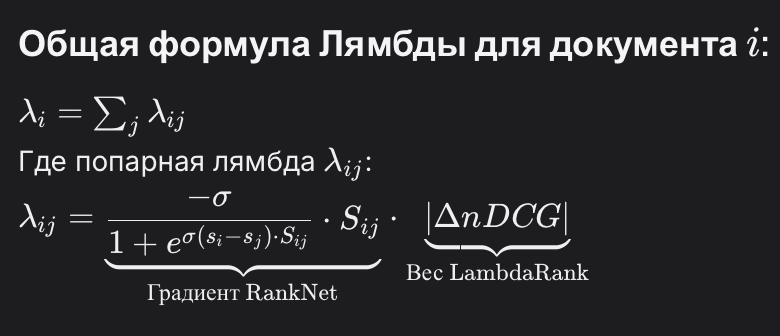

Проблема: Метрики-«ступеньки»
В обычной регрессии (прогноз цены квартиры) функция потерь гладкая: если мы чуть-чуть изменим прогноз, ошибка чуть-чуть изменится. Можно посчитать производную (градиент).

В ранжировании (NDCG) всё иначе:

* NDCG зависит от позиции (ранга) документа.
* Если мы немного изменим скор документа (например, с 0.5 до 0.51), его позиция в списке, скорее всего, не изменится. Значит, NDCG не изменится. Градиент равен 0.
* Если же скор изменится настолько, что документ перепрыгнет соседа, NDCG изменится скачком Градиент в этой точке бесконечен.
Вывод: Мы не можем использовать стандартный градиентный спуск для NDCG.

Что такое Лямбда (λ)?
Авторы алгоритмов LambdaRank и LambdaMART придумали гениальный обходной путь. Они сказали:

«Раз мы не можем дифференцировать саму метрику, давайте сами придумаем виртуальный градиент и назовем его Лямбдой».

Лямбда (λi) для конкретного документа — это число, которое указывает направление и силу (интенсивность) желаемого изменения скора этого документа.

Её можно представить как физическую «силу», которая тянет документ:

* Положительная лямбда: тянет документ «вверх» (увеличивает его скор).
* Отрицательная лямбда: тянет документ «вниз» (уменьшает его скор).

Величина лямбды: показывает, насколько критично для итогового NDCG подвинуть этот документ прямо сейчас.

В нашем коде реализован алгоритм LambdaMART. Его логика в рамках градиентного бустинга следующая:

* Считаем текущие ошибки: Мы берем текущую модель и смотрим, как она отранжировала документы в каждой группе. 
Генерируем «цели» (Лямбды):
* В методе _compute_lambdas мы вычисляем эти силы для каждого документа.

(!) Пары документов, которые стоят в неправильном порядке и находятся близко к топу, получают огромные лямбды (потому что их перестановка сильно увеличит NDCG). Документы, которые и так стоят правильно, получают почти нулевые лямбды.

* Обучаем дерево на лямбды: Мы берем обычный DecisionTreeRegressor.
Вместо того чтобы предсказывать релевантность y (0, 1, 2...), мы заставляем дерево предсказывать лямбды (эти самые виртуальные градиенты).

То есть дерево учится отвечать на вопрос: «На сколько мне нужно изменить скор этого документа, чтобы максимально угодить всем лямбдам?»

Обновляем модель: Мы добавляем предсказания нового дерева к текущим скорам. Теперь документы, которые лямбды «тянули вверх», получили более высокие баллы и поднялись в списке.

+ все внимание на скор! изменяется именно скор!

В LambdaRank лямбды представляют собой псевдоградиенты, которые кодируют не только величину, но и направление оптимизации для ранжирования. Их главная цель:

* Прямая оптимизация ранжирующих метрик (NDCG, MAP) без их дифференцирования
* Учет парных перестановок - каждая лямбда вычисляется для пары документов
* Учет позиционного веса - важность перестановки зависит от позиции в списке

In [28]:
import math
import pickle
import random
from typing import List, Tuple

import numpy as np
import torch
from catboost.datasets import msrank_10k
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm.auto import tqdm

class Solution:
    def __init__(self, n_estimators: int = 100, lr: float = 0.5, ndcg_top_k: int = 10,
                 subsample: float = 0.6, colsample_bytree: float = 0.9,
                 max_depth: int = 5, min_samples_leaf: int = 8):
        self.n_estimators = n_estimators
        self.lr = lr
        self.ndcg_top_k = ndcg_top_k
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        
        self.trees: List[DecisionTreeRegressor] = []
        self.features_indices: List[np.ndarray] = []
        
        self._prepare_data()

    def _get_data(self) -> List[np.ndarray]:
        train_df, test_df = msrank_10k()
        X_train = train_df.drop([0, 1], axis=1).values
        y_train = train_df[0].values
        query_ids_train = train_df[1].values.astype(int)
        X_test = test_df.drop([0, 1], axis=1).values
        y_test = test_df[0].values
        query_ids_test = test_df[1].values.astype(int)
        return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

    def _prepare_data(self) -> None:
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()
        
        X_train_scaled = self._scale_features_in_query_groups(X_train, self.query_ids_train)
        X_test_scaled = self._scale_features_in_query_groups(X_test, self.query_ids_test)

        self.X_train = torch.FloatTensor(X_train_scaled)
        self.X_test = torch.FloatTensor(X_test_scaled)
        self.ys_train = torch.FloatTensor(y_train).reshape(-1, 1)
        self.ys_test = torch.FloatTensor(y_test).reshape(-1, 1)

    def _scale_features_in_query_groups(self, inp_feat_array: np.ndarray,
                                        inp_query_ids: np.ndarray) -> np.ndarray:
        scaled_feats = np.zeros_like(inp_feat_array)
        unique_queries = np.unique(inp_query_ids)
        for qid in unique_queries:
            mask = (inp_query_ids == qid)
            group_feats = inp_feat_array[mask]
            if group_feats.shape[0] > 1:
                scaler = StandardScaler()
                scaled_feats[mask] = scaler.fit_transform(group_feats)
            else:
                scaled_feats[mask] = 0.0
        return scaled_feats

    def _compute_dcg(self, y_true: torch.FloatTensor, y_pred: torch.FloatTensor, k: int) -> float:
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        
        _, indices = torch.sort(y_pred, descending=True)
        indices = indices[:k]
        
        true_sorted = y_true[indices]
        gains = torch.pow(2.0, true_sorted) - 1
        discounts = torch.log2(torch.arange(len(true_sorted)).float() + 2.0)
        return torch.sum(gains / discounts).item()

    def _ndcg_k(self, ys_true: torch.FloatTensor, ys_pred: torch.FloatTensor, ndcg_top_k: int) -> float:
        current_dcg = self._compute_dcg(ys_true, ys_pred, ndcg_top_k)
        ideal_dcg = self._compute_dcg(ys_true, ys_true, ndcg_top_k)
        if ideal_dcg == 0:
            return 0.0
        return current_dcg / ideal_dcg

    def _calc_data_ndcg(self, queries_list: np.ndarray,
                        true_labels: torch.FloatTensor, preds: torch.FloatTensor) -> float:
        ndcgs = []
        unique_queries = np.unique(queries_list)
        for qid in unique_queries:
            mask = (queries_list == qid)
            if torch.sum(true_labels[mask]) == 0:
                continue
            ndcgs.append(self._ndcg_k(true_labels[mask], preds[mask], self.ndcg_top_k))
        return np.mean(ndcgs) if ndcgs else 0.0

    def _compute_lambdas(self, y_true: torch.FloatTensor, y_pred: torch.FloatTensor) -> torch.FloatTensor:
        # Приводим к 1D для ранжирования
        y_true_flat = y_true.view(-1)
        y_pred_flat = y_pred.view(-1)
        
        #нормировка 
        ideal_dcg = self._compute_dcg(y_true, y_true, self.ndcg_top_k)
        if ideal_dcg == 0:
            return torch.zeros_like(y_pred)
        N = 1.0 / ideal_dcg
        
        # Получаем ранги (позиции)
        _, rank_order = torch.sort(y_pred_flat, descending=True)
        ranks = torch.zeros_like(rank_order).float()
        ranks[rank_order] = torch.arange(len(y_pred_flat)).float() + 1
        
        # Снова к 2D для матричных операций
        y_p = y_pred_flat.view(-1, 1)
        y_t = y_true_flat.view(-1, 1)
        r = ranks.view(-1, 1)
        
        with torch.no_grad():
            pos_pairs_score_diff = y_p - y_p.t()
            #разница gain
            gain_diff = torch.pow(2.0, y_t) - torch.pow(2.0, y_t.t())
            #знаменатель gain 
            decay_diff = (1.0 / torch.log2(r + 1.0)) - (1.0 / torch.log2(r.t() + 1.0))

            delta_ndcg = torch.abs(N * gain_diff * decay_diff)
            Sij = torch.sign(y_t - y_t.t())

            sigma = 1.0
            lambda_matrix = -sigma / (1 + torch.exp(sigma * pos_pairs_score_diff * Sij)) * Sij * delta_ndcg
            return torch.sum(lambda_matrix, dim=1, keepdim=True)

    def _train_one_tree(self, cur_tree_idx: int,
                        train_preds: torch.FloatTensor
                        ) -> Tuple[DecisionTreeRegressor, np.ndarray]:
        np.random.seed(cur_tree_idx)
        
        lambdas = torch.zeros_like(self.ys_train)
        unique_queries = np.unique(self.query_ids_train)

        for qid in unique_queries:
            mask = (self.query_ids_train == qid)

            if torch.sum(self.ys_train[mask]) > 0:
                #ΔNDCG для пар и понимает, какие документы нужно «толкать» вверх, а какие вниз.
                lambdas[mask] = self._compute_lambdas(self.ys_train[mask], train_preds[mask])
        
        n_samples = self.X_train.shape[0]
        idx_subsample = np.random.choice(n_samples, int(self.subsample * n_samples), replace=False)
        
        n_features = self.X_train.shape[1]
        idx_colsample = np.random.choice(n_features, int(self.colsample_bytree * n_features), replace=False)
        
        X_batch = self.X_train[idx_subsample][:, idx_colsample].numpy()
        # В нашем коде вычисленные lambdas — это и есть градиенты (∇L). 
        # Поскольку формула обновления в бустинге выглядит как s(new)= s(old) + η⋅Tree(X), 
        # а в градиентном спуске мы должны вычитать градиент,мы заставляем дерево предсказывать градиент с обратным знаком: Tree(X)≈−∇L
        y_batch = -lambdas[idx_subsample].numpy() 
        
        tree = DecisionTreeRegressor(
            max_depth=self.max_depth, 
            min_samples_leaf=self.min_samples_leaf,
            random_state=cur_tree_idx
        )
        tree.fit(X_batch, y_batch)
        return tree, idx_colsample

    def fit(self):
        np.random.seed(0)
        train_preds = torch.zeros_like(self.ys_train)
        test_preds = torch.zeros_like(self.ys_test)
        best_ndcg = -1.0
        best_count = 0
        
        for i in tqdm(range(self.n_estimators), desc="Fitting"):
            tree, col_indices = self._train_one_tree(i, train_preds)
            self.trees.append(tree)
            self.features_indices.append(col_indices)
            
            train_preds += self.lr * torch.FloatTensor(tree.predict(self.X_train[:, col_indices].numpy())).reshape(-1, 1)
            test_preds += self.lr * torch.FloatTensor(tree.predict(self.X_test[:, col_indices].numpy())).reshape(-1, 1)
            
            curr_ndcg = self._calc_data_ndcg(self.query_ids_test, self.ys_test, test_preds)
            if curr_ndcg > best_ndcg:
                best_ndcg = curr_ndcg
                best_count = i + 1
                
        self.trees = self.trees[:best_count]
        self.features_indices = self.features_indices[:best_count]
        print(f"Done! Best NDCG@10: {best_ndcg:.4f} with {best_count} trees.")

    def predict(self, data: torch.FloatTensor) -> torch.FloatTensor:
        preds = torch.zeros(data.shape[0], 1)
        for tree, indices in zip(self.trees, self.features_indices):
            preds += self.lr * torch.FloatTensor(tree.predict(data[:, indices].numpy())).reshape(-1, 1)
        return preds

    def save_model(self, path: str):
        with open(path, 'wb') as f:
            pickle.dump({'trees': self.trees, 'indices': self.features_indices, 'lr': self.lr}, f)

    def load_model(self, path: str):
        with open(path, 'rb') as f:
            state = pickle.load(f)
        self.trees, self.features_indices, self.lr = state['trees'], state['indices'], state['lr']

sol = Solution(
    n_estimators=300, 
    lr=0.5, 
    subsample=0.6, 
    colsample_bytree=0.9,
    max_depth=5, 
    min_samples_leaf=8
)
sol.fit()
model_filename = "solution_model.pkl"
sol.save_model(model_filename)
print(f"\nModel successfully saved to {model_filename}")

print("\nVerifying the saved model...")
new_sol = Solution() 
new_sol.load_model(model_filename)

test_preds = new_sol.predict(new_sol.X_test)
final_ndcg = new_sol._calc_data_ndcg(new_sol.query_ids_test, new_sol.ys_test, test_preds)
print(f"Final NDCG@10 on test set: {final_ndcg:.4f}")

Fitting: 100%|██████████| 300/300 [05:51<00:00,  1.17s/it]


Done! Best NDCG@10: 0.4296 with 260 trees.

Model successfully saved to solution_model.pkl

Verifying the saved model...
Final NDCG@10 on test set: 0.4296


## KNRM

In [6]:
#!pip3 install nltk

* dev для теста; 
* train для тренировки 
В качестве текстовых эмбеддингов будут использоваться вектора GloVe 6B.

Архитектура K-NRM - учитывает взаимосвязи каждый-с-каждым относительно слов запроса и документа. 

В качестве меры близости используется cosine similarity, **однако полученная матрица сворачивается с помощью ядер, или кернелов (kernels).** 

Ядро представляет собой RBF-kernel (Radial Basis Function), который вам может быть знаком из машинного обучения. Каждое такое ядро — это функция от целой строки в матрице взаимодействий M(ij)
​между запросом и документом, или, иными словами, **взаимодействие одного слова из запроса со всеми словами документа за раз.** Это ядро имеет два параметра, которые не обучаются, а фиксируются при инициализации: среднее μ(k) и параметр дисперсии σ(k),который стоит в знаменателе. Эта сигма обычно одинакова для всех ядер (кернелов).



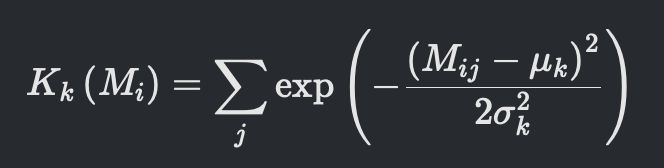

* За счёт среднего, **параметра μ(k), который уникален для каждого ядра, происходит привязка к конкретному значению в исходной матрице схожести,** т.е. к значению similarity, с которым сравнивается каждый элемент матрицы M(ij) попарных взаимодействий эмбеддингов слов запроса и документа. 

Каждое ядро можно представить как волну, где по оси OY отмечен вес, с которым объект, или токен в документе, входит в конкретную область.

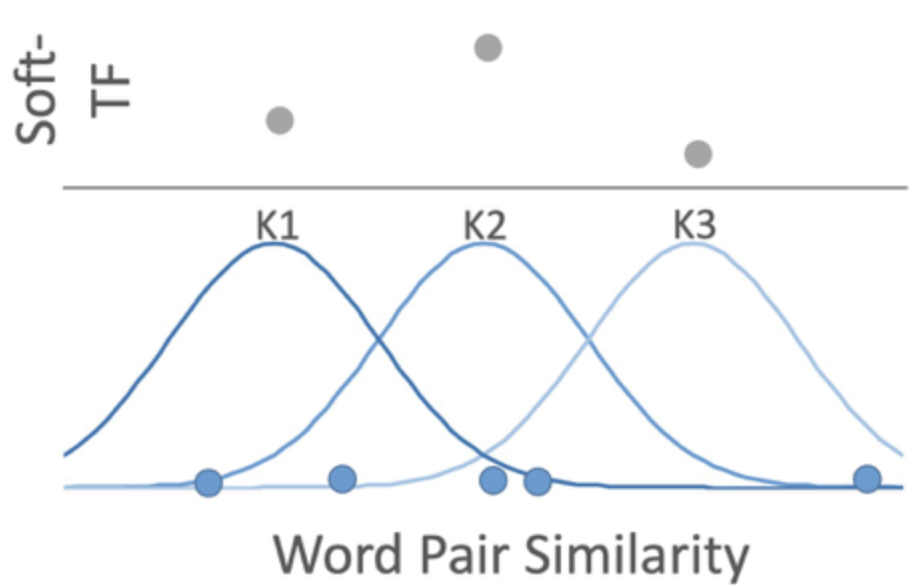

**Синие точки - документы.**

Чем левее точка, тем меньше, вплоть до −1, cosine similarity между словом в документе, которое представлено точкой, и конкретным зафиксированным словом в запросе.

**Серая точка** вверху символизирует выходное значение конкретного ядра. Видно, что второй кернел имеет наибольшее значение

Это обусловлено тем, что близко к его центру находится целых два объекта, т.е. они наиболее похожи именно на центр волны, которая описывает второе ядро. 

Для того чтобы симулировать несколько бинов, т.е. оценивать плотность распределения метрики косинусной схожести слов запроса и документа в разных частях интервала, берётся несколько ядер с некоторым шагом между их средним, т.е. μ (k)​. Допустим, для отрезка [−1,1] будет 11 ядер, у первого cреднее в 1, далее 0.9,0.7 и так далее до −0.9. Тогда каждое из ядер даст скалярное числовое значение на выходе, **характеризующее схожесть запроса и документа в некоторой окрестности определенной cosine similarity** , и объединив все ядра для описания полной картины можно получить вектор. В случае с 11 ядрами, или кернелами, получаем вектор из 11 признаков, который несёт в себе ту же информацию, что и Matching Histogram в DRMM. Собственно, такой вектор и получится K(Mi)={K(1)(M(i)),…,K11(Mi)}.

Для полноты картины осталось осознать, на что влияет параметр σ(k), т.е. дисперсия. 
По сути она задаёт ширину бина, в который попадают слова из документа.
Чем больше σ(k), тем шире бин и тем на большую окрестность обращает внимание этот кернел.

Cамо слово учитывается в каждом бине, но в большинстве из них с околонулевым весом.


Может показаться странным, но в K-NRM из-за замены жестких бинов на сглаженные версии на кернелы появляется возможность дифференцировать весь алгоритм, считать градиенты и прокидывать их на входные эмбеддинги, по которым оценивается косинусная схожесть. Это даёт удивительную возможность дообучать эмбеддинги слов под свою задачу, т.е. в прямом смысле переопределять значения слов и словосочетаний исходя из потребностей. 


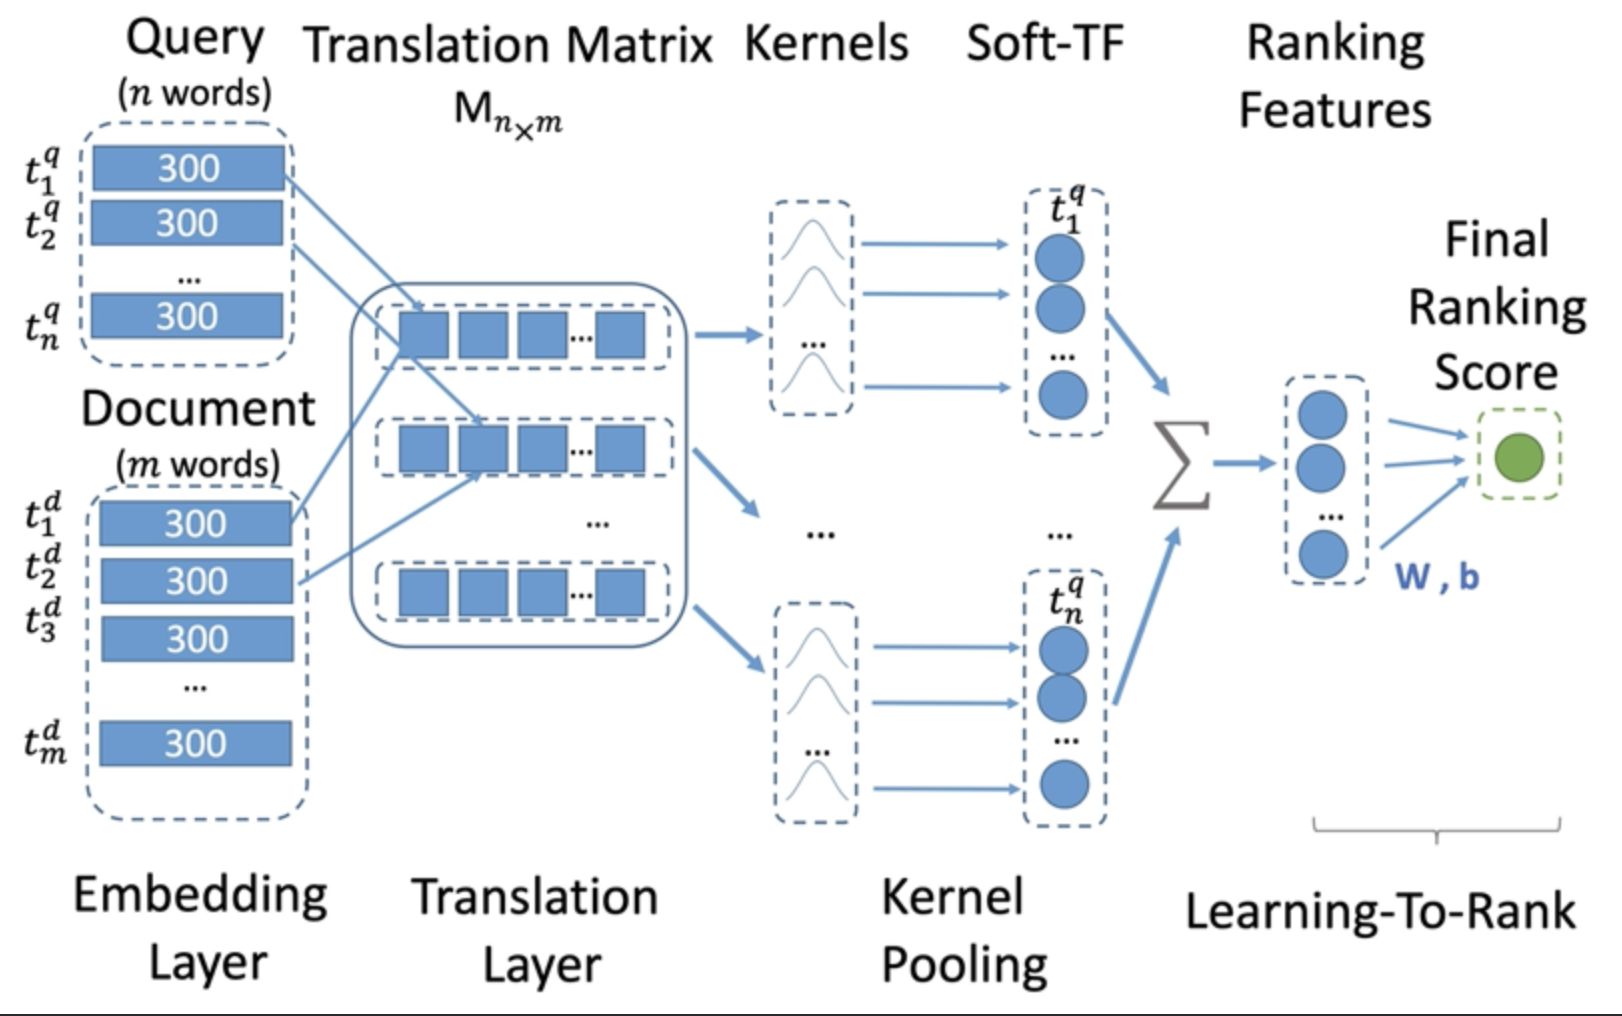

Блок 1. Реализация токенизации и препроцессинга данных

In [21]:
import string
from collections import Counter
from typing import Dict, List, Tuple, Union, Callable

import nltk
import numpy as np
import math
import pandas as pd
import torch
import torch.nn.functional as F

GloVe (эмбеддинги)            QQP (данные)
      ↓                            ↓
[Семантические вектора слов] + [Пары вопросов с метками]
                ↓
         Модель KNRM
                ↓
[Обучение ранжировать вопросы по релевантности]

In [34]:
glue_qqp_dir = '/Users/annarozkova/Desktop/ML/Ранжирование/QQP/' 
glove_path  = '/Users/annarozkova/Desktop/ML/Ранжирование/glove.6B.50d.txt'

In [42]:
import pandas as pd
dev = '/Users/annarozkova/Desktop/ML/Ранжирование/QQP/dev.tsv'
dev = pd.read_csv(dev, sep='\t')
print(dev.head(3))

train = '/Users/annarozkova/Desktop/ML/Ранжирование/QQP/train.tsv'
train = pd.read_csv(train, sep='\t')
print(train.head(3))

       id    qid1    qid2                                          question1  \
0  201359  303345  303346            Why are African-Americans so beautiful?   
1  263843   69383  380476  I want to pursue PhD in Computer Science about...   
2  172974  266948  175089      Is there a reason why we should travel alone?   

                                           question2  is_duplicate  
0                    Why are hispanics so beautiful?             0  
1  I handle social media for a non-profit. Should...             0  
2             What are some reasons to travel alone?             1  
       id    qid1    qid2                                          question1  \
0  133273  213221  213222  How is the life of a math student? Could you d...   
1  402555  536040  536041                How do I control my horny emotions?   
2  360472  364011  490273       What causes stool color to change to yellow?   

                                           question2  is_duplicate  
0  Which leve

In [43]:
train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [24]:
def handle_punctuation(inp_str: str) -> str:
    for s in string.punctuation:
        new_inp_str = inp_str.replace(s,' ')
    return new_inp_str

In [44]:
columns_to_clean = ['question1', 'question2']
train[columns_to_clean] = train[columns_to_clean].apply(lambda x: x.map(handle_punctuation))
train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0
1,402555,536040,536041,How do I control my horny emotions?,How do you control your horniness?,1
2,360472,364011,490273,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0
3,150662,155721,7256,What can one do after MBBS?,What do i do after my MBBS ?,1
4,183004,279958,279959,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0


In [45]:
def _simple_preproc(inp_str: str) -> List[str]:
    inp_str = inp_str.lower()
    token_inp_str = nltk.word_tokenize(inp_str)
    return token_inp_str

In [27]:
columns_to_tokenize = ['question1', 'question2']
train['question1'] = train['question1'].map(_simple_preproc)
train['question2'] = train['question2'].map(_simple_preproc)
train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222,"[how, is, the, life, of, a, math, student, ?, ...","[which, level, of, prepration, is, enough, for...",0
1,402555,536040,536041,"[how, do, i, control, my, horny, emotions, ?]","[how, do, you, control, your, horniness, ?]",1
2,360472,364011,490273,"[what, causes, stool, color, to, change, to, y...","[what, can, cause, stool, to, come, out, as, l...",0


In [46]:
#словарь - {w: c for w, c in vocab.items() if c >= min_occurancies}
def _filter_rare_words(vocab: Dict[str, int], min_occurancies: int) -> Dict[str, int]:
    return {word: count for word, count in vocab.items() if count >= min_occurancies}

get_all_tokens — метод, формирующий список ВСЕХ токенов, представленных в подаваемых на вход датасетах (в pd.DataFrame). Для реализации необходимо сформировать уникальное множество всех текстов, затем рассчитать частотность каждого токена (т.е. после обработки simple_preproc) и отсечь те, которые не проходят порог, равный min_token_occurancies, с помощью метода _filter_rare_words. На выходе — список токенов, для которых будут формироваться эмбеддинги и на которые будут разбиваться оригинальные тексты вопросов.

In [56]:
def get_all_tokens(list_of_df: List[pd.DataFrame], min_occurancies: int) -> List[str]:
    all_tokens = []
    
    for df in list_of_df:
        texts_left = df['question1'].astype(str).tolist()
        texts_right = df['question2'].astype(str).tolist()

        all_texts = texts_left + texts_right
        
        for text in all_texts:
            tokens = _simple_preproc(text)
            all_tokens.extend(tokens)

    token_counts = Counter(all_tokens)
    filtered_tokens = _filter_rare_words(token_counts, min_occurancies)
    return list(filtered_tokens.keys())

In [57]:
tokens = get_all_tokens(list_of_df=[train, dev], min_occurancies=1)
print(f"Всего токенов: {len(tokens)}")
print(f"Первые 10: {tokens[:10]}")

Всего токенов: 112925
Первые 10: ['how', 'is', 'the', 'life', 'of', 'a', 'math', 'student', '?', 'could']


Блок 2. Создание матрицы эмбеддингов и словаря токенов

In [63]:
def _read_glove_embeddings(file_path: str) -> Dict[str, List[str]]:
        # допишите ваш код здесь
        embeddings = {}

        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.strip().split()
                word = values[0]
                vector = values[1:]
                embeddings[word] = vector
        return embeddings

In [ ]:
#embeddings = _read_glove_embeddings(glove_path)
#embeddings

In [68]:
def create_glove_emb_from_file(file_path: str, inner_keys: List[str],
                                   random_seed: int, rand_uni_bound: float
                                   ) -> Tuple[np.ndarray, Dict[str, int], List[str]]:
        np.random.seed(random_seed)
        
        # Читаем GloVe эмбеддинги
        glove_emb = _read_glove_embeddings(file_path)
        
        # Добавляем специальные токены
        vocab = {'PAD': 0, 'OOV': 1}
        emb_matrix = np.zeros((2, len(next(iter(glove_emb.values())))))
        
        unk_words = []
        
        # Создаем эмбеддинги для всех токенов
        for i, token in enumerate(inner_keys, 2):
            vocab[token] = i
            if token in glove_emb:
                emb_matrix = np.vstack([emb_matrix, glove_emb[token]])
            else:
                # Генерируем случайный вектор
                random_emb = np.random.uniform(-rand_uni_bound, rand_uni_bound, 
                                             emb_matrix.shape[1])
                emb_matrix = np.vstack([emb_matrix, random_emb])
                unk_words.append(token)
        
        return emb_matrix, vocab, unk_words

In [ ]:
emb_matrix, vocab, unk_words = create_glove_emb_from_file(
    file_path=glove_path,
    inner_keys=tokens,  # ← именно результаты из get_all_tokens!
    random_seed=42,
    rand_uni_bound=0.2
)

1. Препроцессинг датасета: 

* handle_punctuation - приводим данные к одному виду;
* simple_preproc - должно включать в себя обработку пунктуации и приведение к нижнему регистру, а в качестве токенизации (разбиения предложения на слова или их усеченную версию — токены) необходимо использовать метод nltk.word_tokenize из библиотеки nltk. На выходе — лист со строками (токенами);
* get_all_tokens — метод, формирующий список ВСЕХ токенов, представленных в подаваемых на вход датасетах (в pd.DataFrame). 

2. Создание матрицы эмбеддингов и словаря токенов

* _read_glove_embeddings — считывание файла эмбеддингов в словарь после get_all_tokens

* create_glove_emb_from_file — метод формирует matrix

- PAD и OOV, с индексами 0 и 1 соответственно. Первый токен используется для заполнения пустот в тензорах.и должен состоять полностью из нулей. Второй токен используется для токенов, которых нет в словаре. 

3. 
_get_kernels_layers — формирует список всех ядер (K штук), применяемых в алгоритме. 
_get_mlp — формирует выходной MLP-слой для ранжирования на основе результата Kernels.

In [5]:
glue_qqp_dir = '/ML/Ранжирование/QQP/'
glove_path = '/ML/Ранжирование/glove.6B.50d.txt'

In [ ]:
class GaussianKernel(torch.nn.Module):
    def __init__(self, mu: float = 1., sigma: float = 1.):
        super().__init__()
        self.mu = mu
        self.sigma = sigma

    def forward(self, x):
        # допишите ваш код здесь
        
        pass

In [ ]:
class KNRM(torch.nn.Module):
    def __init__(self, embedding_matrix: np.ndarray, freeze_embeddings: bool, kernel_num: int = 21,
                 sigma: float = 0.1, exact_sigma: float = 0.001,
                 out_layers: List[int] = [10, 5]):
        super().__init__()
        self.embeddings = torch.nn.Embedding.from_pretrained(
            torch.FloatTensor(embedding_matrix),
            freeze=freeze_embeddings,
            padding_idx=0
        )

        self.kernel_num = kernel_num
        self.sigma = sigma
        self.exact_sigma = exact_sigma
        self.out_layers = out_layers

        self.kernels = self._get_kernels_layers()

        self.mlp = self._get_mlp()

        self.out_activation = torch.nn.Sigmoid()

    def _get_kernels_layers(self) -> torch.nn.ModuleList:
        kernels = torch.nn.ModuleList()
        # допишите ваш код здесь
        for _ in range(self.kernel_num):
            

        return kernels

    def _get_mlp(self) -> torch.nn.Sequential:
       # допишите ваш код здесь
       pass

    def forward(self, input_1: Dict[str, torch.Tensor], input_2: Dict[str, torch.Tensor]) -> torch.FloatTensor:
        logits_1 = self.predict(input_1)
        logits_2 = self.predict(input_2)

        logits_diff = logits_1 - logits_2

        out = self.out_activation(logits_diff)
        return out

    def _get_matching_matrix(self, query: torch.Tensor, doc: torch.Tensor) -> torch.FloatTensor:
        # допишите ваш код здесь
        pass

    def _apply_kernels(self, matching_matrix: torch.FloatTensor) -> torch.FloatTensor:
        KM = []
        for kernel in self.kernels:
            # shape = [B]
            K = torch.log1p(kernel(matching_matrix).sum(dim=-1)).sum(dim=-1)
            KM.append(K)

        # shape = [B, K]
        kernels_out = torch.stack(KM, dim=1)
        return kernels_out

    def predict(self, inputs: Dict[str, torch.Tensor]) -> torch.FloatTensor:
        # shape = [Batch, Left], [Batch, Right]
        query, doc = inputs['query'], inputs['document']
        # shape = [Batch, Left, Right]
        matching_matrix = self._get_matching_matrix(query, doc)
        # shape = [Batch, Kernels]
        kernels_out = self._apply_kernels(matching_matrix)
        # shape = [Batch]
        out = self.mlp(kernels_out)
        return out

In [ ]:
class RankingDataset(torch.utils.data.Dataset):
    def __init__(self, index_pairs_or_triplets: List[List[Union[str, float]]],
                 idx_to_text_mapping: Dict[str, str], vocab: Dict[str, int], oov_val: int,
                 preproc_func: Callable, max_len: int = 30):
        self.index_pairs_or_triplets = index_pairs_or_triplets
        self.idx_to_text_mapping = idx_to_text_mapping
        self.vocab = vocab
        self.oov_val = oov_val
        self.preproc_func = preproc_func
        self.max_len = max_len

    def __len__(self):
        return len(self.index_pairs_or_triplets)

    def _tokenized_text_to_index(self, tokenized_text: List[str]) -> List[int]:
        # допишите ваш код здесь
        pass

    def _convert_text_idx_to_token_idxs(self, idx: int) -> List[int]:
        # допишите ваш код здесь
        pass

    def __getitem__(self, idx: int):
        pass

In [ ]:
class TrainTripletsDataset(RankingDataset):
    def __getitem__(self, idx):
        # допишите ваш код здесь
        pass

class ValPairsDataset(RankingDataset):
    def __getitem__(self, idx):
        # допишите ваш код здесь
        pass


def collate_fn(batch_objs: List[Union[Dict[str, torch.Tensor], torch.FloatTensor]]):
    max_len_q1 = -1
    max_len_d1 = -1
    max_len_q2 = -1
    max_len_d2 = -1

    is_triplets = False
    for elem in batch_objs:
        if len(elem) == 3:
            left_elem, right_elem, label = elem
            is_triplets = True
        else:
            left_elem, label = elem

        max_len_q1 = max(len(left_elem['query']), max_len_q1)
        max_len_d1 = max(len(left_elem['document']), max_len_d1)
        if len(elem) == 3:
            max_len_q2 = max(len(right_elem['query']), max_len_q2)
            max_len_d2 = max(len(right_elem['document']), max_len_d2)

    q1s = []
    d1s = []
    q2s = []
    d2s = []
    labels = []

    for elem in batch_objs:
        if is_triplets:
            left_elem, right_elem, label = elem
        else:
            left_elem, label = elem

        pad_len1 = max_len_q1 - len(left_elem['query'])
        pad_len2 = max_len_d1 - len(left_elem['document'])
        if is_triplets:
            pad_len3 = max_len_q2 - len(right_elem['query'])
            pad_len4 = max_len_d2 - len(right_elem['document'])

        q1s.append(left_elem['query'] + [0] * pad_len1)
        d1s.append(left_elem['document'] + [0] * pad_len2)
        if is_triplets:
            q2s.append(right_elem['query'] + [0] * pad_len3)
            d2s.append(right_elem['document'] + [0] * pad_len4)
        labels.append([label])
    q1s = torch.LongTensor(q1s)
    d1s = torch.LongTensor(d1s)
    if is_triplets:
        q2s = torch.LongTensor(q2s)
        d2s = torch.LongTensor(d2s)
    labels = torch.FloatTensor(labels)

    ret_left = {'query': q1s, 'document': d1s}
    if is_triplets:
        ret_right = {'query': q2s, 'document': d2s}
        return ret_left, ret_right, labels
    else:
        return ret_left, labels

In [ ]:
class Solution:
    def __init__(self, glue_qqp_dir: str, glove_vectors_path: str,
                 min_token_occurancies: int = 1,
                 random_seed: int = 0,
                 emb_rand_uni_bound: float = 0.2,
                 freeze_knrm_embeddings: bool = True,
                 knrm_kernel_num: int = 21,
                 knrm_out_mlp: List[int] = [],
                 dataloader_bs: int = 1024,
                 train_lr: float = 0.001,
                 change_train_loader_ep: int = 10
                 ):
        self.glue_qqp_dir = glue_qqp_dir
        self.glove_vectors_path = glove_vectors_path
        self.glue_train_df = self.get_glue_df('train')
        self.glue_dev_df = self.get_glue_df('dev')
        self.dev_pairs_for_ndcg = self.create_val_pairs(self.glue_dev_df)
        self.min_token_occurancies = min_token_occurancies
        self.all_tokens = self.get_all_tokens(
            [self.glue_train_df, self.glue_dev_df], self.min_token_occurancies)

        self.random_seed = random_seed
        self.emb_rand_uni_bound = emb_rand_uni_bound
        self.freeze_knrm_embeddings = freeze_knrm_embeddings
        self.knrm_kernel_num = knrm_kernel_num
        self.knrm_out_mlp = knrm_out_mlp
        self.dataloader_bs = dataloader_bs
        self.train_lr = train_lr
        self.change_train_loader_ep = change_train_loader_ep

        self.model, self.vocab, self.unk_words = self.build_knrm_model()
        self.idx_to_text_mapping_train = self.get_idx_to_text_mapping(
            self.glue_train_df)
        self.idx_to_text_mapping_dev = self.get_idx_to_text_mapping(
            self.glue_dev_df)

        self.val_dataset = ValPairsDataset(self.dev_pairs_for_ndcg,
              self.idx_to_text_mapping_dev,
              vocab=self.vocab, oov_val=self.vocab['OOV'],
              preproc_func=self.simple_preproc)
        self.val_dataloader = torch.utils.data.DataLoader(
            self.val_dataset, batch_size=self.dataloader_bs, num_workers=0,
            collate_fn=collate_fn, shuffle=False)

    def get_glue_df(self, partition_type: str) -> pd.DataFrame:
        assert partition_type in ['dev', 'train']
        glue_df = pd.read_csv(
            self.glue_qqp_dir + f'/{partition_type}.tsv', sep='\t', error_bad_lines=False, dtype=object)
        glue_df = glue_df.dropna(axis=0, how='any').reset_index(drop=True)
        glue_df_fin = pd.DataFrame({
            'id_left': glue_df['qid1'],
            'id_right': glue_df['qid2'],
            'text_left': glue_df['question1'],
            'text_right': glue_df['question2'],
            'label': glue_df['is_duplicate'].astype(int)
        })
        return glue_df_fin
    
    def handle_punctuation(self, inp_str: str) -> str:
        # Заменяем пунктуацию на пробелы
        for punct in string.punctuation:
            inp_str = inp_str.replace(punct, ' ')
        return inp_str

    def simple_preproc(self, inp_str: str) -> List[str]:
        # Очистка от пунктуации, нижний регистр, токенизация
        cleaned = self.handle_punctuation(inp_str.lower())
        tokens = nltk.word_tokenize(cleaned)
        return tokens

    def _filter_rare_words(self, vocab: Dict[str, int], min_occurancies: int) -> Dict[str, int]:
        return {word: count for word, count in vocab.items() if count >= min_occurancies}

    def get_all_tokens(self, list_of_df: List[pd.DataFrame], min_occurancies: int) -> List[str]:
        all_texts = []
        for df in list_of_df:
            all_texts.extend(df['text_left'].tolist())
            all_texts.extend(df['text_right'].tolist())
        
        all_tokens = []
        token_counter = Counter()
        
        for text in all_texts:
            tokens = self.simple_preproc(text)
            all_tokens.extend(tokens)
            token_counter.update(tokens)
        
        # Фильтруем редкие слова
        frequent_tokens = [token for token, count in token_counter.items() 
                          if count >= min_occurancies]
        
        return sorted(frequent_tokens)

    def _read_glove_embeddings(self, file_path: str) -> Dict[str, List[str]]:
        # допишите ваш код здесь
        embeddings = {}

        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.strip().split()
                word = values[0]
                vector = values[1:]
                embeddings[word] = vector
        return embeddings
        
    def create_glove_emb_from_file(self, file_path: str, inner_keys: List[str],
                                   random_seed: int, rand_uni_bound: float
                                   ) -> Tuple[np.ndarray, Dict[str, int], List[str]]:
        np.random.seed(random_seed)
        
        # Читаем GloVe эмбеддинги
        glove_emb = self._read_glove_embeddings(file_path)
        
        # Добавляем специальные токены
        vocab = {'PAD': 0, 'OOV': 1}
        emb_matrix = np.zeros((2, len(next(iter(glove_emb.values())))))
        
        unk_words = []
        
        # Создаем эмбеддинги для всех токенов
        for i, token in enumerate(inner_keys, 2):
            vocab[token] = i
            if token in glove_emb:
                emb_matrix = np.vstack([emb_matrix, glove_emb[token]])
            else:
                # Генерируем случайный вектор
                random_emb = np.random.uniform(-rand_uni_bound, rand_uni_bound, 
                                             emb_matrix.shape[1])
                emb_matrix = np.vstack([emb_matrix, random_emb])
                unk_words.append(token)
        
        return emb_matrix, vocab, unk_words  

    def build_knrm_model(self) -> Tuple[torch.nn.Module, Dict[str, int], List[str]]:
        emb_matrix, vocab, unk_words = self.create_glove_emb_from_file(
            self.glove_vectors_path, self.all_tokens, self.random_seed, self.emb_rand_uni_bound)
        torch.manual_seed(self.random_seed)
        knrm = KNRM(emb_matrix, freeze_embeddings=self.freeze_knrm_embeddings,
                    out_layers=self.knrm_out_mlp, kernel_num=self.knrm_kernel_num)
        return knrm, vocab, unk_words

    def sample_data_for_train_iter(self, inp_df: pd.DataFrame, seed: int
                                   ) -> List[List[Union[str, float]]]:
        # допишите ваш код здесь
        pass

    def create_val_pairs(self, inp_df: pd.DataFrame, fill_top_to: int = 15,
                         min_group_size: int = 2, seed: int = 0) -> List[List[Union[str, float]]]:
        inp_df_select = inp_df[['id_left', 'id_right', 'label']]
        inf_df_group_sizes = inp_df_select.groupby('id_left').size()
        glue_dev_leftids_to_use = list(
            inf_df_group_sizes[inf_df_group_sizes >= min_group_size].index)
        groups = inp_df_select[inp_df_select.id_left.isin(
            glue_dev_leftids_to_use)].groupby('id_left')

        all_ids = set(inp_df['id_left']).union(set(inp_df['id_right']))

        out_pairs = []

        np.random.seed(seed)

        for id_left, group in groups:
            ones_ids = group[group.label > 0].id_right.values
            zeroes_ids = group[group.label == 0].id_right.values
            sum_len = len(ones_ids) + len(zeroes_ids)
            num_pad_items = max(0, fill_top_to - sum_len)
            if num_pad_items > 0:
                cur_chosen = set(ones_ids).union(
                    set(zeroes_ids)).union({id_left})
                pad_sample = np.random.choice(
                    list(all_ids - cur_chosen), num_pad_items, replace=False).tolist()
            else:
                pad_sample = []
            for i in ones_ids:
                out_pairs.append([id_left, i, 2])
            for i in zeroes_ids:
                out_pairs.append([id_left, i, 1])
            for i in pad_sample:
                out_pairs.append([id_left, i, 0])
        return out_pairs

    def get_idx_to_text_mapping(self, inp_df: pd.DataFrame) -> Dict[str, str]:
        left_dict = (
            inp_df
            [['id_left', 'text_left']]
            .drop_duplicates()
            .set_index('id_left')
            ['text_left']
            .to_dict()
        )
        right_dict = (
            inp_df
            [['id_right', 'text_right']]
            .drop_duplicates()
            .set_index('id_right')
            ['text_right']
            .to_dict()
        )
        left_dict.update(right_dict)
        return left_dict

    def ndcg_k(self, ys_true: np.array, ys_pred: np.array, ndcg_top_k: int = 10) -> float:
        # допишите ваш код здесь  (обратите внимание, что используются вектора numpy)
        pass

    def valid(self, model: torch.nn.Module, val_dataloader: torch.utils.data.DataLoader) -> float:
        labels_and_groups = val_dataloader.dataset.index_pairs_or_triplets
        labels_and_groups = pd.DataFrame(labels_and_groups, columns=['left_id', 'right_id', 'rel'])

        all_preds = []
        for batch in (val_dataloader):
            inp_1, y = batch
            preds = model.predict(inp_1)
            preds_np = preds.detach().numpy()
            all_preds.append(preds_np)
        all_preds = np.concatenate(all_preds, axis=0)
        labels_and_groups['preds'] = all_preds

        ndcgs = []
        for cur_id in labels_and_groups.left_id.unique():
            cur_df = labels_and_groups[labels_and_groups.left_id == cur_id]
            ndcg = self.ndcg_k(cur_df.rel.values.reshape(-1), cur_df.preds.values.reshape(-1))
            if np.isnan(ndcg):
                ndcgs.append(0)
            else:
                ndcgs.append(ndcg)
        return np.mean(ndcgs)

    def train(self, n_epochs: int):
        opt = torch.optim.SGD(self.model.parameters(), lr=self.train_lr)
        criterion = torch.nn.BCELoss()
        # допишите ваш код здесь
        pass
